### Instalação de pacotes

In [3]:
!powershell pip install \
            face_recognition \
            git+https://github.com/ageitgey/face_recognition_models \
            opencv-python \
            pillow \
            numpy \
            tqdm \
            qdrant-client \
            setuptools \
            ipywidgets \
            matplotlib \
            scikit-learn \
            scikit-image

  Cloning https://github.com/ageitgey/face_recognition_models to c:\users\despinxz\appdata\local\temp\pip-req-build-qu1mdb6m
  Resolved https://github.com/ageitgey/face_recognition_models to commit e67de717267507d1e9246de95692eb8be736ab61
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/ageitgey/face_recognition_models 'C:\Users\despinxz\AppData\Local\Temp\pip-req-build-qu1mdb6m'


### Rodar QDrant

In [4]:
!powershell docker run -p 6333:6333 -p 6334:6334 qdrant/qdrant

^C


### Imports

In [5]:
import os
import uuid
import numpy as np
from tqdm import tqdm
import tkinter as tk
from tkinter import filedialog
import face_recognition
import face_recognition_models
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams, PointStruct
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams
from qdrant_client.models import Filter, SearchRequest
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn
import skimage

### Configurações

In [6]:
def cria_cliente():
    # Conectando ao Qdrant local
    client = QdrantClient("http://localhost:6333")
    return client

def cria_colecao(client, nome_colecao, tamanho_vetor):
    # Cria a coleção se não existir
    if nome_colecao not in [c.name for c in client.get_collections().collections]:
        client.recreate_collection(
            collection_name=nome_colecao,
            vectors_config=VectorParams(size=tamanho_vetor, distance=Distance.COSINE),
        )

### Códigos para processar imagens

Gerar vetor de características por Local Binary Patterns

In [7]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern

def extrai_caracteristicas_lbp(caminho_imagem):
    imagem = cv2.imread(caminho_imagem)
    # Converte imagem para tons de cinza
    imagem_cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

    metodo = 'uniform'
    vetor_final = []

    # Para radius 1, 2 e 3
    for raio in [1, 2, 3]:
        n_pontos = 8 * raio

        # Aplica o LBP
        lbp = local_binary_pattern(imagem_cinza, n_pontos, raio, metodo)

        # Número de bins: n_pontos + 2 para o método 'uniform'
        n_bins = n_pontos + 2
        hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

        # Adiciona o histograma ao vetor final
        vetor_final.extend(hist)

    id_ponto = str(uuid.uuid4())    # ID único 

    nome_pessoa_aux = caminho_imagem.split("\\")[-1].split(".")[0]
    nome_pessoa = nome_pessoa_aux.split("_")[0] + nome_pessoa_aux.split("_")[1]

    # Cria estrutura de ponto para inserir na coleção
    ponto = PointStruct(
            id=id_ponto,
            vector=vetor_final,
            payload={"nome": nome_pessoa, "arquivo": caminho_imagem})

    return ponto


Gerar vetor de características por descritores faciais de landmarks

In [8]:
import cv2
import numpy as np
import face_recognition

def alinhar_rosto_por_landmarks(imagem_bgr, tamanho_saida=(160, 160)):
    imagem_rgb = cv2.cvtColor(imagem_bgr, cv2.COLOR_BGR2RGB)
    landmarks_list = face_recognition.face_landmarks(imagem_rgb)

    if not landmarks_list:
        return None  # Nenhum rosto detectado

    landmarks = landmarks_list[0]

    # Pega posição dos olhos (centro de cada olho)
    olho_esquerdo = np.mean(landmarks['left_eye'], axis=0)
    olho_direito = np.mean(landmarks['right_eye'], axis=0)

    # Calcula ângulo de rotação
    dx = olho_direito[0] - olho_esquerdo[0]
    dy = olho_direito[1] - olho_esquerdo[1]
    angulo = np.degrees(np.arctan2(dy, dx))

    # Ponto central entre os olhos
    centro_olhos_np = (olho_esquerdo + olho_direito) / 2
    centro_olhos = (float(centro_olhos_np[0]), float(centro_olhos_np[1]))


    # Matriz de rotação
    M = cv2.getRotationMatrix2D(centro_olhos, angulo, scale=1.0)

    # Aplica rotação
    imagem_rotacionada = cv2.warpAffine(imagem_bgr, M, (imagem_bgr.shape[1], imagem_bgr.shape[0]))

    # Opcional: detectar novamente o rosto e centralizar / crop após rotação
    imagem_alinhada = cv2.resize(imagem_rotacionada, tamanho_saida)

    return imagem_alinhada


In [9]:
import face_recognition
import numpy as np
import cv2

def extrai_caracteristicas_landmarks(caminho_imagem):
    imagem = cv2.imread(caminho_imagem)
    imagem_alinhada = alinhar_rosto_por_landmarks(imagem)

    if imagem_alinhada is None:
        vetor = np.zeros(136)    

    else: 
        imagem_rgb = cv2.cvtColor(imagem_alinhada, cv2.COLOR_BGR2RGB)
        # Detecta landmarks faciais
        face_landmarks_list = face_recognition.face_landmarks(imagem_rgb)
        if not face_landmarks_list:
            vetor = np.zeros(136)
        else:
            # Pegamos os landmarks da primeira face detectada
            landmarks = face_landmarks_list[0]

            # Reorganiza os pontos na ordem correta (68 pontos padrão)
            pontos = []
            for key in ['chin', 'left_eyebrow', 'right_eyebrow', 'nose_bridge', 'nose_tip',
                        'left_eye', 'right_eye', 'top_lip', 'bottom_lip']:
                for ponto in landmarks[key]:
                    pontos.append(ponto)

            # Garante que temos sempre 68 pontos
            if len(pontos) < 68:
                pontos += [(0, 0)] * (68 - len(pontos))

            # Normaliza por largura e altura da imagem
            h, w = imagem.shape[:2]
            vetor = []
            for (x, y) in pontos[:68]:
                vetor.append(x / w)
                vetor.append(y / h)

    id_ponto = str(uuid.uuid4())    # ID único 

    nome_pessoa_aux = caminho_imagem.split("\\")[-1].split(".")[0]
    nome_pessoa = nome_pessoa_aux.split("_")[0] + nome_pessoa_aux.split("_")[1]

    # Cria estrutura de ponto para inserir na coleção
    ponto = PointStruct(
            id=id_ponto,
            vector=vetor,
            payload={"nome": nome_pessoa, "arquivo": caminho_imagem})


    return ponto


Gerar vetor de características antropométricas

In [ ]:
import face_recognition
import numpy as np
import cv2
import uuid
from qdrant_client.models import PointStruct

def distancia(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

def extrai_caracteristicas_antropometricas(caminho_imagem, indices_selecionados=[]):
    try:
        imagem = cv2.imread(caminho_imagem)
        if imagem is None:
            raise ValueError("Imagem não carregada")

        imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
        landmarks_list = face_recognition.face_landmarks(imagem_rgb)

        if not landmarks_list:
            raise ValueError("Nenhum rosto detectado")

        landmarks = landmarks_list[0]

        def ponto_medio(pontos):
            return np.mean(pontos, axis=0)

        # Pontos principais
        olho_esq = ponto_medio(landmarks['left_eye'])
        olho_dir = ponto_medio(landmarks['right_eye'])
        sobrancelha_esq = ponto_medio(landmarks['left_eyebrow'])
        sobrancelha_dir = ponto_medio(landmarks['right_eyebrow'])
        nariz_topo = landmarks['nose_bridge'][0]
        nariz_base = ponto_medio(landmarks['nose_tip'])
        boca_canto_esq = landmarks['top_lip'][0]
        boca_canto_dir = landmarks['top_lip'][6]
        boca_meio_sup = ponto_medio([landmarks['top_lip'][3], landmarks['top_lip'][4]])
        boca_meio_inf = ponto_medio([landmarks['bottom_lip'][9], landmarks['bottom_lip'][10]])
        queixo = landmarks['chin'][8]
        centro_olhos = (olho_esq + olho_dir) / 2

        # Pontos extras
        queixo_esq = landmarks['chin'][0]
        queixo_dir = landmarks['chin'][-1]
        largura_olho_esq = distancia(landmarks['left_eye'][0], landmarks['left_eye'][3])
        largura_olho_dir = distancia(landmarks['right_eye'][0], landmarks['right_eye'][3])
        dist_sobrancelha_nariz_esq = distancia(sobrancelha_esq, nariz_base)
        dist_sobrancelha_nariz_dir = distancia(sobrancelha_dir, nariz_base)
        dist_boca_queixo = distancia(boca_meio_inf, queixo)

        # Medidas diretas
        medidas = {
            "dist_entre_olhos": distancia(olho_esq, olho_dir),
            "largura_nariz": distancia(landmarks['nose_tip'][0], landmarks['nose_tip'][-1]),
            "altura_nariz": distancia(nariz_topo, nariz_base),
            "largura_boca": distancia(boca_canto_esq, boca_canto_dir),
            "altura_boca": distancia(boca_meio_sup, boca_meio_inf),
            "altura_face": distancia(queixo, centro_olhos),
            "largura_face": distancia(landmarks['chin'][0], landmarks['chin'][-1]),
            "sobrancelha_olho_esq": distancia(olho_esq, sobrancelha_esq),
            "sobrancelha_olho_dir": distancia(olho_dir, sobrancelha_dir),
            "largura_olho_esq": largura_olho_esq,
            "largura_olho_dir": largura_olho_dir,
            "dist_sobrancelha_nariz_esq": dist_sobrancelha_nariz_esq,
            "dist_sobrancelha_nariz_dir": dist_sobrancelha_nariz_dir,
            "dist_boca_queixo": dist_boca_queixo
        } 

        # Proporções derivadas
        proporcoes = {
            "boca_nariz_ratio": medidas["largura_boca"] / medidas["largura_nariz"],
            "boca_face_ratio": medidas["largura_boca"] / medidas["largura_face"],
            "altura_largura_nariz": medidas["altura_nariz"] / medidas["largura_nariz"],
            "boca_face_altura_ratio": medidas["altura_boca"] / medidas["altura_face"],
            "simetria_sobrancelhas": medidas["sobrancelha_olho_esq"] / medidas["sobrancelha_olho_dir"],
            "simetria_olhos": medidas["largura_olho_esq"] / medidas["largura_olho_dir"],
            "simetria_sobrancelha_nariz": medidas["dist_sobrancelha_nariz_esq"] / medidas["dist_sobrancelha_nariz_dir"],
            "boca_queixo_ratio": medidas["largura_boca"] / medidas["dist_boca_queixo"]
        }

        vetor = list(medidas.values()) + list(proporcoes.values())

        # Normalização pela largura da face
        largura_ref = medidas["largura_face"]
        vetor_normalizado = [v / largura_ref for v in vetor]

    except Exception as e:
        print(f"[ERRO] {caminho_imagem}: {str(e)}")
        vetor_normalizado = [0.0] * 22  # número fixo das dimensões do vetor final

    # Se houver seleção de características
    if len(indices_selecionados) > 0:
        vetor_final = [vetor_normalizado[i] for i in indices_selecionados]
    else:
        vetor_final = vetor_normalizado

    # Preparar identificação
    id_ponto = str(uuid.uuid4())
    nome_pessoa_aux = caminho_imagem.split("\\")[-1].split(".")[0]
    partes = nome_pessoa_aux.split("_")
    nome_pessoa = partes[0] + partes[1] if len(partes) >= 2 else partes[0]

    ponto = PointStruct(
        id=id_ponto,
        vector=vetor_final,
        payload={
            "nome": nome_pessoa,
            "arquivo": caminho_imagem
        }
    )

    return ponto


Gerar vetor de características por CNN

In [11]:
def extrai_caracteristicas_cnn(caminho_imagem):
    imagem = face_recognition.load_image_file(caminho_imagem)
    embeddings = face_recognition.face_encodings(imagem)
    if not embeddings:
        vetor = np.zeros(128)  # Nenhum rosto detectado
    else:
        vetor = embeddings[0]

    id_ponto = str(uuid.uuid4())    # ID único 

    nome_pessoa_aux = caminho_imagem.split("\\")[-1].split(".")[0]
    nome_pessoa = nome_pessoa_aux.split("_")[0] + nome_pessoa_aux.split("_")[1]


    # Cria estrutura de ponto para inserir na coleção
    ponto = PointStruct(
            id=id_ponto,
            vector=vetor,
            payload={"nome": nome_pessoa, "arquivo": caminho_imagem})

    return ponto

### Código para selecionar diretórios e separar conjuntos de treino e validação

In [12]:
import os
import random
from sklearn.model_selection import train_test_split

def separa_treino_validacao_lfw(base_dir, proporcao_treino=0.8):
    caminhos_treino = []
    caminhos_validacao = []

    for nome_pessoa in os.listdir(base_dir):
        caminho_pessoa = os.path.join(base_dir, nome_pessoa)

        if not os.path.isdir(caminho_pessoa):
            continue

        imagens = [os.path.join(caminho_pessoa, img) for img in os.listdir(caminho_pessoa)
                   if img.lower().endswith(('.jpg', '.png', '.jpeg'))]

        total_imagens = len(imagens)

        if total_imagens not in [8, 10, 12]:
            continue

        imagens.sort()  # garantir consistência
        random.seed(42)  # garantir que o shuffle será o mesmo em todas as execuções do código
        random.shuffle(imagens)

        treino, validacao = train_test_split(imagens, train_size=proporcao_treino, shuffle=False)

        caminhos_treino.extend(treino)
        caminhos_validacao.extend(validacao)

    return caminhos_treino, caminhos_validacao


Calcular acurácia

In [14]:
from tqdm import tqdm

def avaliar_metodo(client, metodo, k=1):
    col_validacao = f"{metodo}_validacao"
    col_treinamento = f"{metodo}_treinamento"
    acertos = 0
    total = 0
    ignorados = 0

    # Percorre os vetores da coleção de validação
    pontos_validacao, _ = client.scroll(
        collection_name=col_validacao,
        with_vectors=True,
        with_payload=True,
        limit=100_000  # ou um valor grande o suficiente para garantir que todos sejam retornados
    )

    
    for ponto in tqdm(pontos_validacao, desc=f"Avaliando {metodo}"):
        vetor = ponto.vector
        if vetor is None or not isinstance(vetor, list) or len(vetor) == 0:
            ignorados += 1
            continue

        nome_consulta = ponto.payload.get("nome", "").split("_")[0]

        # Consulta similaridade no conjunto de treinamento
        resultados = client.search(
            collection_name=col_treinamento,
            query_vector=vetor,
            limit=k,
            with_payload=True
        )

        if not resultados:
            ignorados += 1
            continue

        nome_mais_proximo = resultados[0].payload.get("nome", "").split("_")[0]
        if nome_consulta == nome_mais_proximo:
            acertos += 1
        total += 1

    acc = acertos / total if total > 0 else 0
    print(f"Acurácia ({metodo}): {acc:.4f} ({acertos}/{total})")
    print(f"Total de vetores inválidos ignorados: {ignorados}")


Seleção de caracteristicas antropometricas

In [ ]:
# Seleção de caracteristicas
from sklearn.feature_selection import SelectKBest, f_classif

imagens_treino, imagens_validacao = separa_treino_validacao_lfw("lfw_funneled")

num_anthr_carac = 14
vetores = []
nomes = []
for img in imagens_treino:
    ponto = extrai_caracteristicas_antropometricas(img)
    vetores.append(ponto.vector)
    nomes.append(ponto.payload["nome"])

seletor = SelectKBest(f_classif, k=num_anthr_carac)
vetores_reduzidos = seletor.fit_transform(vetores, nomes)
indices_selecionados = seletor.get_support(indices=True)

# selecao manual: 0.2540 - [0,1,2,3,4,5,6,7,8,14,15,16,17,19]
# acuracia antes de selecionar caracteristicas: 0.2302 
# acuracia selecionando caracteristicas (13): 0.1746 - [ 1,  2,  3,  4,  5,  7,  8, 11, 12, 13, 14, 16, 17, 21]
# acuracia selecionando caracteristicas (14): 0.1746 - [ 1,  2,  3,  4,  5,  7,  8, 11, 12, 13, 14, 16, 17, 21]
# acuracia selecionando caracteristicas (15): 0.1746 
# acuracia selecionando caracteristicas (17): 0.2302 - [ 0,  1,  2,  3,  4,  5,  7,  8, 11, 12, 13, 14, 15, 16, 17, 18, 21]
# acuracia selecionando caracteristicas (19): 0.2063 - [ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21]

indices_selecionados

# Main

Inicia cliente e cria coleções

In [ ]:
client = cria_cliente()


n_lbp = 54
n_landmarks = 136
n_cnn = 128
n_anthr = 14 #22

# Cria coleções para cada método de avaliação
cria_colecao(client, "lbp_treinamento", n_lbp)
cria_colecao(client, "lbp_validacao", n_lbp)
cria_colecao(client, "landmarks_treinamento", n_landmarks)
cria_colecao(client, "landmarks_validacao", n_landmarks)
cria_colecao(client, "cnn_treinamento", n_cnn)
cria_colecao(client, "cnn_validacao", n_cnn)
cria_colecao(client, "anthropometric_treinamento", n_anthr)
cria_colecao(client, "anthropometric_validacao", n_anthr)

C:\Users\despinxz\AppData\Local\Temp\ipykernel_8960\814055332.py:9: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


Processa imagens e cria vetores de pontos para serem inseridos nas coleções

In [ ]:
imagens_treino, imagens_validacao = separa_treino_validacao_lfw("lfw_funneled")

indices_selecionados = [0,1,2,3,4,5,6,7,8,14,15,16,17,19] # seleção de caracteristicas antropometricas
caracteristicas_lbp_treino = []
caracteristicas_landmark_treino = []
caracteristicas_cnn_treino = []
caracteristicas_anthropometric_treino = []

for imagem in tqdm(imagens_treino, desc="Processando imagens de treinamento..."):
    caracteristicas_lbp_treino.append(extrai_caracteristicas_lbp(imagem))
    caracteristicas_landmark_treino.append(extrai_caracteristicas_landmarks(imagem))
    caracteristicas_cnn_treino.append(extrai_caracteristicas_cnn(imagem))
    caracteristicas_anthropometric_treino.append(extrai_caracteristicas_antropometricas(imagem, indices_selecionados))

caracteristicas_lbp_validacao = []
caracteristicas_landmark_validacao = []
caracteristicas_cnn_validacao = []
caracteristicas_anthropometric_validacao = []

for imagem in tqdm(imagens_validacao, desc="Processando imagens de validação..."):
    caracteristicas_lbp_validacao.append(extrai_caracteristicas_lbp(imagem))
    caracteristicas_landmark_validacao.append(extrai_caracteristicas_landmarks(imagem))
    caracteristicas_cnn_validacao.append(extrai_caracteristicas_cnn(imagem))
    caracteristicas_anthropometric_validacao.append(extrai_caracteristicas_antropometricas(imagem, indices_selecionados))

Processando imagens de treinamento...:   9%|▉         | 36/408 [00:21<02:48,  2.21it/s]

[ERRO] lfw_funneled\Anna_Kournikova\Anna_Kournikova_0005.jpg: Nenhum rosto detectado


Processando imagens de treinamento...:  38%|███▊      | 157/408 [01:32<01:56,  2.16it/s]

[ERRO] lfw_funneled\Jelena_Dokic\Jelena_Dokic_0004.jpg: Nenhum rosto detectado


Processando imagens de treinamento...:  99%|█████████▉| 403/408 [04:01<00:02,  2.16it/s]

[ERRO] lfw_funneled\Yasser_Arafat\Yasser_Arafat_0004.jpg: Nenhum rosto detectado


Processando imagens de validação...: 100%|██████████| 126/126 [01:21<00:00,  1.55it/s]


In [112]:
caracteristicas_lbp_treino0 = caracteristicas_lbp_treino
caracteristicas_landmark_treino0 = caracteristicas_landmark_treino
caracteristicas_cnn_treino0 = caracteristicas_cnn_treino
caracteristicas_anthropometric_treino0 = caracteristicas_anthropometric_treino
caracteristicas_lbp_validacao0 = caracteristicas_lbp_validacao
caracteristicas_landmark_validacao0 = caracteristicas_landmark_validacao
caracteristicas_cnn_validacao0 = caracteristicas_cnn_validacao
caracteristicas_anthropometric_validacao0 = caracteristicas_anthropometric_validacao

Insere nas coleções

In [ ]:
client.upsert(collection_name="lbp_treinamento", points=caracteristicas_lbp_treino)
client.upsert(collection_name="lbp_validacao", points=caracteristicas_lbp_validacao)
client.upsert(collection_name="landmarks_treinamento", points=caracteristicas_landmark_treino)
client.upsert(collection_name="landmarks_validacao", points=caracteristicas_landmark_validacao)
client.upsert(collection_name="cnn_treinamento", points=caracteristicas_cnn_treino)
client.upsert(collection_name="cnn_validacao", points=caracteristicas_cnn_validacao)
client.upsert(collection_name="anthropometric_treinamento", points=caracteristicas_anthropometric_treino)
client.upsert(collection_name="anthropometric_validacao", points=caracteristicas_anthropometric_validacao)

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

In [ ]:
for metodo in ["lbp", "landmarks", "cnn", "anthropometric"]:
    avaliar_metodo(client, metodo)

Avaliando lbp:   0%|          | 0/126 [00:00<?, ?it/s]C:\Users\despinxz\AppData\Local\Temp\ipykernel_8960\2917339095.py:28: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  resultados = client.search(
Avaliando lbp: 100%|██████████| 126/126 [00:01<00:00, 90.59it/s] 


Acurácia (lbp): 0.0476 (6/126)
Total de vetores inválidos ignorados: 0


Avaliando landmarks: 100%|██████████| 126/126 [00:01<00:00, 96.55it/s] 


Acurácia (landmarks): 0.1825 (23/126)
Total de vetores inválidos ignorados: 0


Avaliando cnn: 100%|██████████| 126/126 [00:01<00:00, 84.67it/s]


Acurácia (cnn): 1.0000 (126/126)
Total de vetores inválidos ignorados: 0


Avaliando anthropometric: 100%|██████████| 126/126 [00:01<00:00, 89.57it/s]

Acurácia (anthropometric): 0.1746 (22/126)
Total de vetores inválidos ignorados: 0


Acurácia (lbp): 0.0476 (6/126)
Acurácia (landmarks): 0.1825 (23/126)
Acurácia (cnn): 1.0000 (126/126)
Acurácia (anthropometric): 0.1746 (22/126)

In [ ]:
client.delete_collection("lbp_treinamento")
client.delete_collection("lbp_validacao")
client.delete_collection("landmarks_treinamento")
client.delete_collection("landmarks_validacao")
client.delete_collection("cnn_treinamento")
client.delete_collection("cnn_validacao")
client.delete_collection("anthropometric_treinamento")
client.delete_collection("anthropometric_validacao")

True

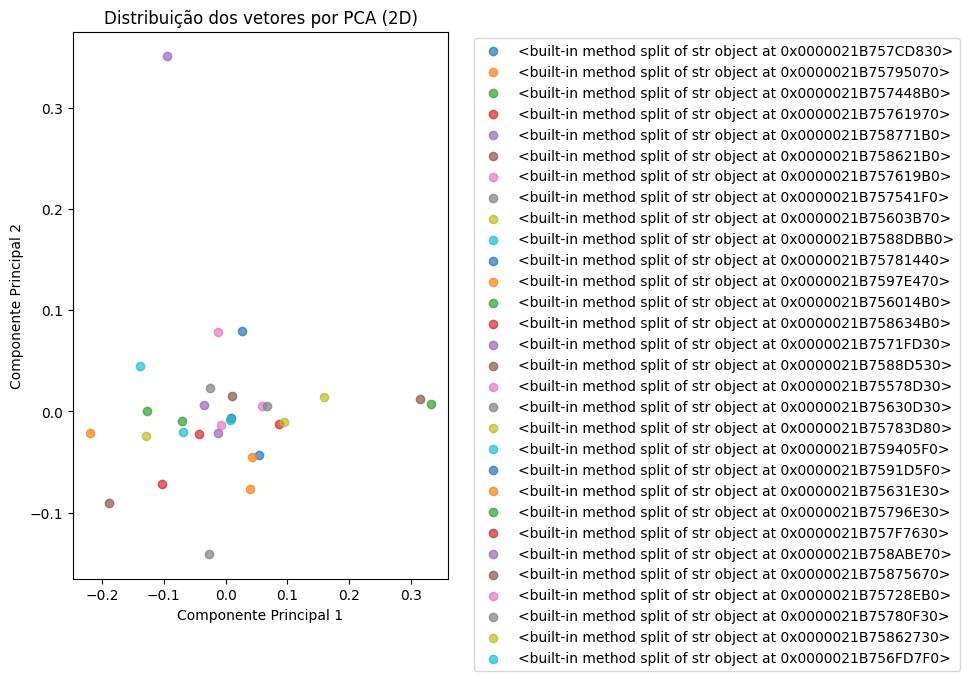

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import random

# Supõe que você já tenha vetores e nomes:
vetores = [p.vector for p in caracteristicas_landmark_treino]
nomes = [p.payload["nome"].split for p in caracteristicas_landmark_treino]

# Seleciona 50 amostras aleatórias
amostras = random.sample(list(zip(vetores, nomes)), k=30)
vetores_amostrados, nomes_amostrados = zip(*amostras)

# PCA para 2D
pca = PCA(n_components=2)
X_2d = pca.fit_transform(vetores_amostrados)

# Plot
plt.figure(figsize=(10, 7))
for nome in set(nomes_amostrados):
    indices = [i for i, n in enumerate(nomes_amostrados) if n == nome]
    plt.scatter(X_2d[indices, 0], X_2d[indices, 1], label=nome, alpha=0.7)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Distribuição dos vetores por PCA (2D)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.tight_layout()
plt.show()


In [ ]:
from qdrant_client.http import models

for metodo in ["lbp", "landmarks", "cnn"]:
    nome_col = f"{metodo}_validacao"
    print(f"\n🔍 Primeiros pontos de {nome_col}:")
    resultados = client.scroll(
        collection_name=nome_col,
        limit=3,
        with_vectors=True,
        with_payload=True
    )
    for ponto in resultados[0]:
        print(" - ID:", ponto.id)
        print("   Nome:", ponto.payload.get("nome"))
        print("   Vetor:", ponto.vector[:5], "...")  # mostra só os 5 primeiros valores



🔍 Primeiros pontos de lbp_validacao:


UnexpectedResponse: Unexpected Response: 404 (Not Found)
Raw response content:
b'{"status":{"error":"Not found: Collection `lbp_validacao` doesn\'t exist!"},"time":9.341e-6}'